In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
import seaborn as sns
from scipy import io
from sklearn.metrics.pairwise import rbf_kernel

In [2]:
sns.set(rc={'figure.figsize':(10, 6)})

In [3]:
class SVM:
    def __init__(self):
        pass
    
    def Kernel(self, X, Y=None, ktype='linear', gamma=None):
        if ktype == 'linear':
            return np.matmul(X, X.T)
        if ktype == 'rbf':
            # gamma is equal to 1/sigma**2, where sigma is standard
            # deviation
            return rbf_kernel(X, Y, gamma)
        else:
            print('Error! {} kernel is not defined!'.format(ktype))
    
    def Train(self, X, y, C, ktype='linear', gamma=None):
        # Save parameters to use them in Prediction and plot functions
        self.ktype = ktype
        self.gamma = gamma
        self.C = C
        y = y.astype('double')
        y[y == 0.] = -1
        
        m, n = X.shape
        
        # to utilize cvxopt library parameters should be in matrix form
        # so we need to rewrite optimization problem in vectorized way
        K = self.Kernel(X, ktype=ktype, gamma=gamma)
        I = np.eye(m)
        h1 = np.ones((m,1))*C
        h2 = np.zeros((m,1))
        
        P = cvxopt.matrix(np.outer(y,y)*K)
        q = cvxopt.matrix(np.ones(m)*(-1))
        G = cvxopt.matrix(np.vstack((I,-I)))
        h = cvxopt.matrix(np.vstack((h1,h2)))
        A = cvxopt.matrix(y.T)
        b = cvxopt.matrix(0.0)
        
        solution = cvxopt.solvers.qp(P,q,G,h,A,b)
        
        # solution is an array of coefficients, most of which is close to
        # zero. It is useful to filter these values by thershold to save
        # support vectors with significant weights
        alphas = np.array(solution['x'])
        threshold = 1e-3
        sv_ids = np.where(alphas > threshold)[0]

        self.alphas = alphas[sv_ids]
        self.sv = X[sv_ids]
        self.sv_y = y[sv_ids]

        # Now we can calculate normal vector and b coefficient derived 
        # analytically
        K_sv = self.Kernel(self.sv, ktype=ktype, gamma=gamma)
        self.b = np.sum(self.sv_y) -\
                np.sum(np.matmul(K_sv, self.alphas*self.sv_y))
        self.b /= len(self.alphas)
        self.w = np.sum(self.alphas*self.sv_y*self.sv, axis=0)
        
    def Predict(self, X):
        if self.ktype == 'linear':
            return np.sign(np.matmul(self.w, X.T) + self.b)
        if self.ktype == 'rbf':
            K = self.Kernel(self.sv, X, 'rbf', self.gamma)
            f = np.matmul((self.alphas*self.sv_y).T, K) + self.b
            return np.sign(f)

In [4]:
def VisualizeData(X, y, title):
    plt.scatter(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1],
            marker='+', c='r')
    plt.scatter(X[np.where(y==0)[0],0],X[np.where(y==0)[0],1],
            marker='_', c='g')
    plt.title(title)
    plt.show()

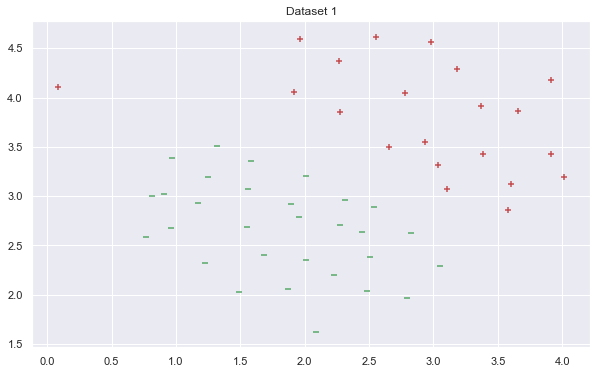

In [5]:
data1 = io.loadmat('data1.mat')
X = data1['X']
y = data1['y'].astype(int)

VisualizeData(X, y, 'Dataset 1')

In [6]:
model = SVM()
C = 1
model.Train(X, y, C)

     pcost       dcost       gap    pres   dres
 0: -1.1833e+01 -9.1932e+01  4e+02  2e+00  1e-14
 1: -6.7902e+00 -4.9791e+01  6e+01  2e-01  1e-14
 2: -5.4665e+00 -1.0706e+01  6e+00  1e-02  9e-15
 3: -7.1271e+00 -8.4670e+00  1e+00  3e-03  7e-15
 4: -7.5827e+00 -7.8912e+00  3e-01  5e-04  1e-14
 5: -7.7167e+00 -7.7491e+00  3e-02  4e-05  1e-14
 6: -7.7309e+00 -7.7322e+00  1e-03  2e-06  1e-14
 7: -7.7315e+00 -7.7315e+00  1e-05  2e-08  1e-14
 8: -7.7315e+00 -7.7315e+00  1e-07  2e-10  1e-14
Optimal solution found.


In [7]:
def SupportLine(X, w, b, c):
    return -(w[0]*X + b + c)/w[1]

In [8]:
xs = np.linspace(min(X[:,0]), max(X[:,0]), 100)

hyperplane = SupportLine(xs, model.w, model.b, 0)
bot_support = SupportLine(xs, model.w, model.b, 1)
top_support = SupportLine(xs, model.w, model.b, -1)

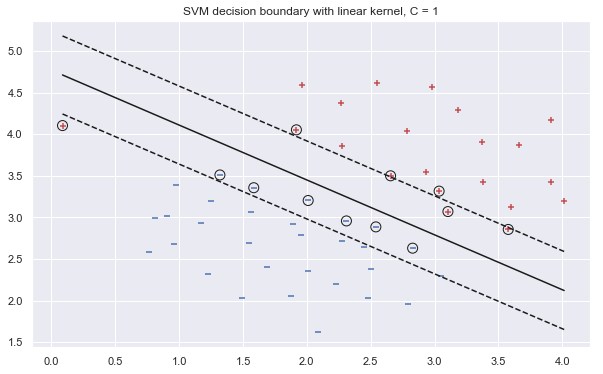

In [9]:
plt.scatter(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1],
            marker='+', c='r')
plt.scatter(model.sv[:,0], model.sv[:,1], 
            marker='o', facecolors='none', edgecolors='k', s=100)
plt.scatter(X[np.where(y==0)[0],0],X[np.where(y==0)[0],1],
            marker='_', c='b')
plt.title('SVM decision boundary with linear kernel, C = {}'.format(C))
plt.plot(xs, hyperplane, 'k')
plt.plot(xs, bot_support, 'k--')
plt.plot(xs, top_support, 'k--')
plt.show()

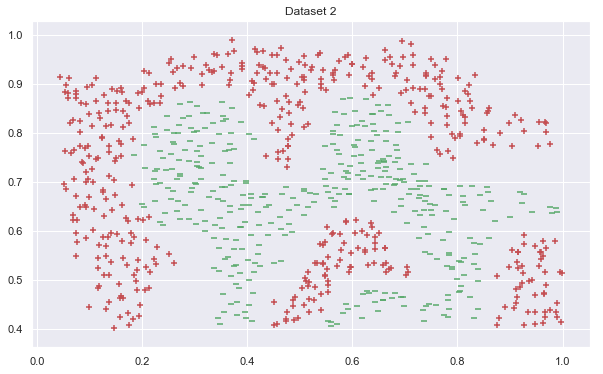

In [10]:
data_2 = io.loadmat('data2.mat')
X = data_2['X']
y = data_2['y'].astype(int)

VisualizeData(X, y, 'Dataset 2')

In [11]:
model = SVM()
model.Train(X, y, 1, 'rbf', 50)

     pcost       dcost       gap    pres   dres
 0: -1.0682e+02 -1.3574e+03  5e+03  2e+00  3e-15
 1: -6.9182e+01 -6.8305e+02  8e+02  1e-01  2e-15
 2: -8.2091e+01 -2.1167e+02  1e+02  2e-02  2e-15
 3: -1.0114e+02 -1.4667e+02  5e+01  5e-03  2e-15
 4: -1.0751e+02 -1.3336e+02  3e+01  2e-03  2e-15
 5: -1.1286e+02 -1.2291e+02  1e+01  7e-04  2e-15
 6: -1.1550e+02 -1.1808e+02  3e+00  4e-05  2e-15
 7: -1.1630e+02 -1.1697e+02  7e-01  2e-14  2e-15
 8: -1.1657e+02 -1.1666e+02  9e-02  1e-14  2e-15
 9: -1.1661e+02 -1.1662e+02  9e-03  7e-15  2e-15
10: -1.1661e+02 -1.1661e+02  1e-04  2e-14  2e-15
11: -1.1661e+02 -1.1661e+02  2e-06  2e-14  2e-15
Optimal solution found.


In [16]:
def ComputeZ(model, u, v):
    Z = model.Predict(np.c_[np.ravel(u), np.ravel(v)])
    return Z.reshape(u.shape)

def CreateGrid(X, n):
    u = np.linspace(min(X[:,0]), max(X[:,0]), n)
    v = np.linspace(min(X[:,1]), max(X[:,1]), n)
    return np.meshgrid(u, v)

def VisualizeDecisionBoundary(Z, u, v, X, y, model):
    plt.contour(u, v, Z, 0)
    plt.scatter(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1],
            marker='+', c='r')
    plt.scatter(X[np.where(y==0)[0],0], X[np.where(y==0)[0],1],
            marker='_', c='g')
    plt.title("SVM decision boundary with {} kernel\n".format(model.ktype)+\
              "C = {}, $\gamma$ = {}".format(model.C, model.gamma))
    plt.xlim((min(X[:,0]), max(X[:,0])))
    plt.ylim((min(X[:,1]), max(X[:,1])))
    plt.show()

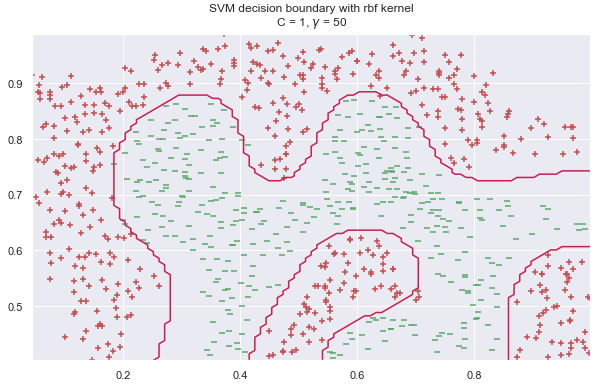

In [17]:
u, v = CreateGrid(X, 100)
Z = ComputeZ(model, u, v)

VisualizeDecisionBoundary(Z, u, v, X, y, model)